In [1]:
import torch
torch.set_default_dtype(torch.float64)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.special import jn_zeros
from scipy.integrate import quad

In [2]:
'''
j0_zeros_array = torch.tensor([
    2.4048, 5.5201, 8.6537, 11.7915, 14.9309,
    18.0711, 21.2116, 24.3525, 27.4935, 30.6346,
    33.7758, 36.9171, 40.0584, 43.1998, 46.3412,
    49.4826, 52.6241, 55.7655, 58.9070, 62.0484,
    65.1899, 68.3313, 71.4728, 74.6142, 77.7557,
    80.8971, 84.0386, 87.1800, 90.3215, 93.4629,
    96.6044, 99.7458, 102.8872, 106.0287, 109.1701,
    112.3116, 115.4530, 118.5944, 121.7359, 124.8773,
    128.0187, 131.1602, 134.3016, 137.4431, 140.5845,
    143.7259, 146.8674, 150.0088, 153.1502, 156.2917
])
'''
j0_zeros_array=torch.tensor(jn_zeros(0,200))

In [3]:
def get_psi(t):
    return t*torch.tanh(torch.pi/2 *torch.sinh(t))

def get_psi_prime(t):
    return torch.tanh(torch.pi/2 * torch.sinh(t)) + torch.pi/2*t*(1-torch.tanh(torch.pi*torch.sinh(t)/2)**2)*torch.cosh(t)

In [4]:
def ogata_weights(xi):
    return 2/(torch.pi**2 * xi * torch.square(torch.special.bessel_j1(torch.pi*xi)))

In [5]:
def eval_ogata_func(func_in, qT, Nmax, h=0.0001):
    xi_vals = j0_zeros_array[:Nmax]/torch.pi
    psi_vals = get_psi(h*xi_vals)
    psip_vals = get_psi_prime(h*xi_vals)
    func_eval_points = torch.pi/h *psi_vals[None,:] /qT[:,None]
    func_vals = func_in((torch.pi/h) *psi_vals[None,:] /qT[:,None])
    j_vals = torch.special.bessel_j0((torch.pi/h) *psi_vals) #psi_vals[None,:]*qT[:,None])
    
    weights = ogata_weights(xi_vals)
    return (torch.pi/qT * torch.sum(weights*func_vals*j_vals*psip_vals,axis=1), func_eval_points)
    #return (torch.pi * torch.sum(weights*func_vals*j_vals*psip_vals,axis=1), func_eval_points)

In [6]:
test_func = lambda x : x*torch.special.scaled_modified_bessel_k0(x)*torch.exp(-x)
#test_func = lambda x : x**2
true_func = lambda x : 1/(1**2 + torch.square(x))

In [7]:
qT_vals = torch.logspace(-3,torch.log10(torch.tensor(20)),500)
bT_vals = torch.logspace(-3,2,500)
data_arr = {}
evals = {}
max_rel_err=[]
ave_rel_err=[]
for NN in range(1,201):
    data_arr[NN],evals[NN] = eval_ogata_func(test_func,qT_vals,NN)
    ave_rel_err.append(100*torch.abs((data_arr[NN]-true_func(qT_vals)/true_func(qT_vals))).mean())
    max_rel_err.append(100*torch.abs((data_arr[NN]-true_func(qT_vals)/true_func(qT_vals))).max())
print(evals[100].max())
print(qT_vals[0])
evals[5].shape
data_arr[5].shape

tensor(4909.8511)
tensor(0.0010)


torch.Size([500])

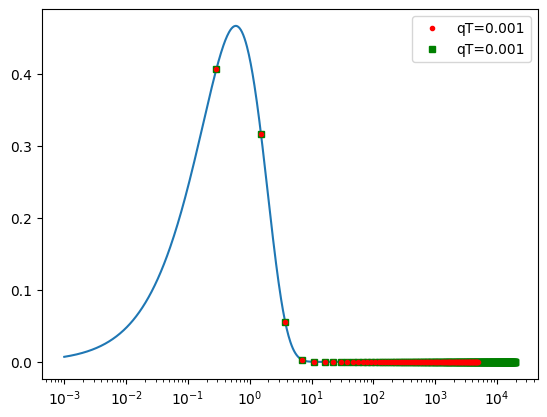

In [8]:
fig=plt.figure()
plt.plot(bT_vals, test_func(bT_vals))
plt.plot(evals[100][0], test_func(evals[100][0]), 'r.', zorder=200, label=f'qT={qT_vals[0]}')
plt.plot(evals[200][0], test_func(evals[200][0]), 'gs', markersize=4,label=f'qT={qT_vals[0]}')
#plt.plot(evals[100][300], test_func(evals[100][300]), 'g.', label = f'qT={qT_vals[300]}')
plt.semilogx()
plt.legend(loc=0)

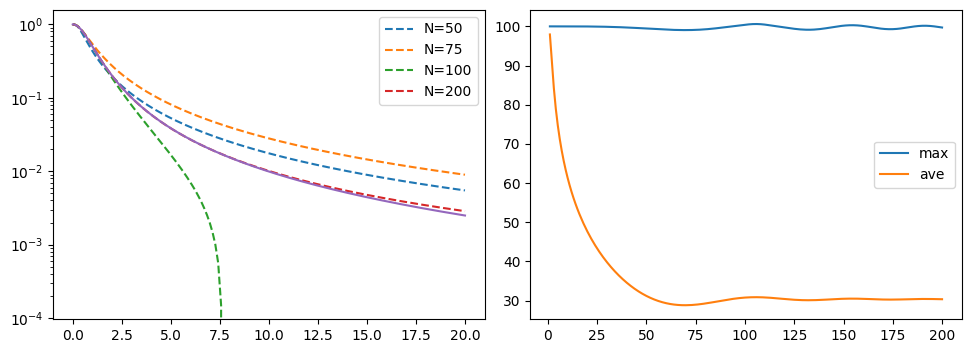

In [9]:
fig = plt.figure(layout='constrained',figsize=[9.6,9.6])
gs = GridSpec(3,2, figure=fig)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0,1])
for NN in [50, 75, 100, 200]:
    ax11.plot(qT_vals, data_arr[NN], linestyle='--',label=f'N={NN}');

ax11.plot(qT_vals, true_func(qT_vals));
ax11.semilogy()
#ax11.semilogx()
ax11.legend(loc=0)
ax12.plot([i for i in range(1,201)],max_rel_err,label='max');
ax12.plot([i for i in range(1,201)],ave_rel_err,label='ave');
ax12.legend(loc=0);

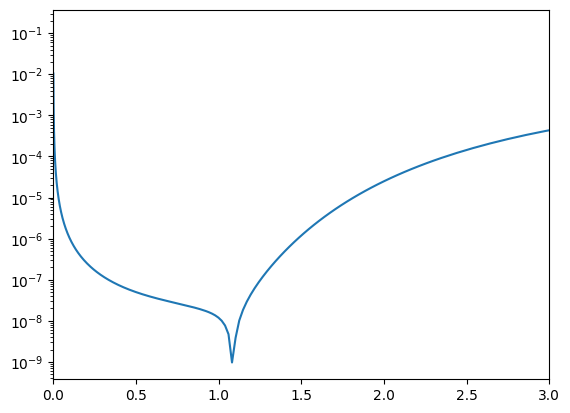

In [10]:
fig=plt.figure()
#plt.plot(qT_vals, (data_arr[100]-true_func(qT_vals))/true_func(qT_vals))
plt.plot(qT_vals, torch.abs((data_arr[200]-true_func(qT_vals))/true_func(qT_vals)))
plt.xlim(0,3)
plt.semilogy()
plt.axhline(0)

# Adjusted

In [11]:
def eval_ogata_func(func_in, qT, Nmax, h=0.0001):
    xi_vals = j0_zeros_array[:Nmax]/torch.pi
    psi_vals = get_psi(h*xi_vals)
    psip_vals = get_psi_prime(h*xi_vals)
    func_eval_points = torch.pi/h *psi_vals[None,:]# /qT[:,None]
    func_vals = func_in((torch.pi/h) *psi_vals[None,:])# /qT[:,None])
    j_vals = torch.special.bessel_j0((torch.pi/h) * psi_vals[None,:]*qT[:,None])
    
    weights = ogata_weights(xi_vals)
    #return (torch.pi/qT * torch.sum(weights*func_vals*j_vals*psip_vals,axis=1), func_eval_points)
    return (torch.pi * torch.sum(weights*func_vals*j_vals*psip_vals,axis=1), func_eval_points)

In [12]:
test_func = lambda x : x*torch.special.scaled_modified_bessel_k0(x)*torch.exp(-x)
#test_func = lambda x : x**2
true_func = lambda x : 1/(1**2 + torch.square(x))

In [13]:
qT_vals = torch.logspace(-3,torch.log10(torch.tensor(20)),500)
bT_vals = torch.logspace(-3,2,500)
data_arr = {}
evals = {}
max_rel_err=[]
ave_rel_err=[]
for NN in range(1,201):
    data_arr[NN],evals[NN] = eval_ogata_func(test_func,qT_vals,NN)
    ave_rel_err.append(100*torch.abs((data_arr[NN]-true_func(qT_vals)/true_func(qT_vals))).mean())
    max_rel_err.append(100*torch.abs((data_arr[NN]-true_func(qT_vals)/true_func(qT_vals))).max())
print(evals[100].max())
print(qT_vals[0])
evals[5].shape
data_arr[5].shape

tensor(4.9099)
tensor(0.0010)


torch.Size([500])

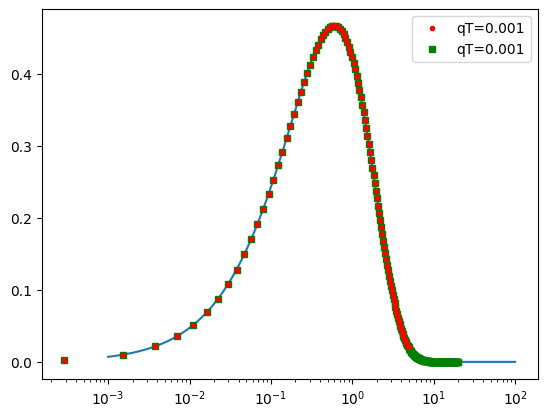

In [14]:
fig=plt.figure()
plt.plot(bT_vals, test_func(bT_vals))
plt.plot(evals[100][0], test_func(evals[100][0]), 'r.', zorder=200, label=f'qT={qT_vals[0]}')
plt.plot(evals[200][0], test_func(evals[200][0]), 'gs', markersize=4,label=f'qT={qT_vals[0]}')
#plt.plot(evals[100][300], test_func(evals[100][300]), 'g.', label = f'qT={qT_vals[300]}')
plt.semilogx()
plt.legend(loc=0)

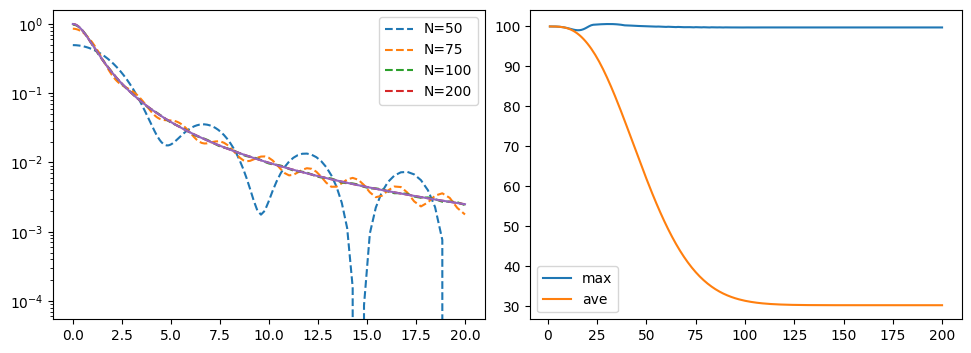

In [15]:
fig = plt.figure(layout='constrained',figsize=[9.6,9.6])
gs = GridSpec(3,2, figure=fig)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0,1])
for NN in [50, 75, 100, 200]:
    ax11.plot(qT_vals, data_arr[NN], linestyle='--',label=f'N={NN}');

ax11.plot(qT_vals, true_func(qT_vals));
ax11.semilogy()
#ax11.semilogx()
ax11.legend(loc=0)
ax12.plot([i for i in range(1,201)],max_rel_err,label='max');
ax12.plot([i for i in range(1,201)],ave_rel_err,label='ave');
ax12.legend(loc=0);

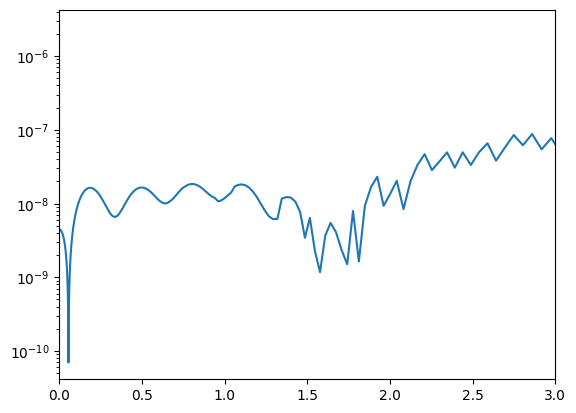

In [16]:
fig=plt.figure()
#plt.plot(qT_vals, (data_arr[100]-true_func(qT_vals))/true_func(qT_vals))
plt.plot(qT_vals, torch.abs((data_arr[200]-true_func(qT_vals))/true_func(qT_vals)))
plt.xlim(0,3)
plt.semilogy()
plt.axhline(0)

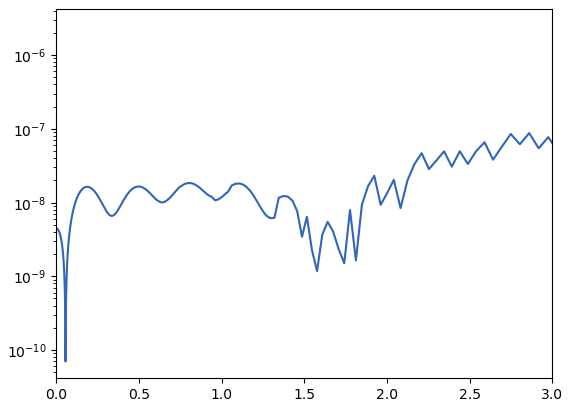
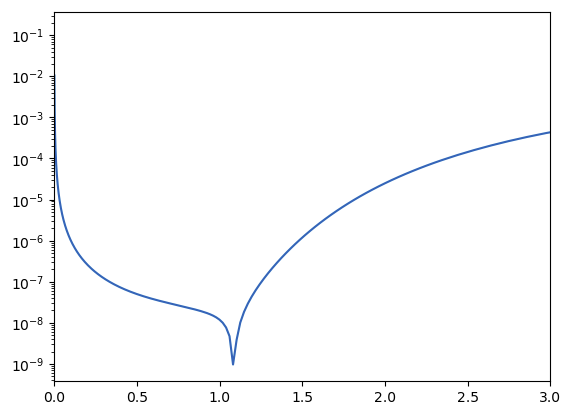

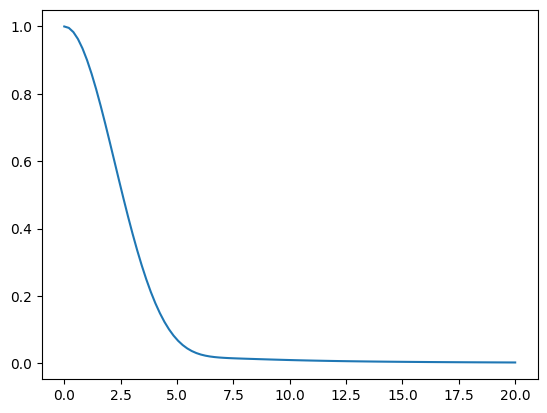

In [17]:
ff1 = lambda qT : np.exp(-qT**2/10)
ff2 = lambda qT : 1/(qT**2+1)
def ff3(qT):
    r = (np.tanh(-0.5*(qT-6))+1)/2
    return r*ff1(qT) + (1-r)*ff2(qT)
qT_range = np.linspace(0,20,100)
fig=plt.figure()
#plt.plot(qT_range, ff1(qT_range))
#plt.plot(qT_range, ff2(qT_range))
plt.plot(qT_range, ff3(qT_range))
#plt.semilogy()
#plt.ylim(1e-3,2)

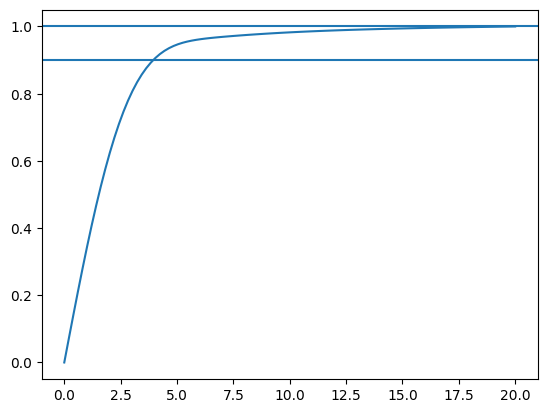

In [18]:
def int_ff3(qmax):
    return quad(ff3,0,qmax)[0]/quad(ff3, 0, 20)[0]
fig=plt.figure()
plt.plot(qT_range, [int_ff3(i) for i in qT_range])
plt.axhline(1.0)
plt.axhline(0.9)

# Gaussian

In [19]:
test_func = lambda x : -x**2 *torch.exp(-x**2/2)
#test_func = lambda x : x**2
true_func = lambda x : torch.exp(-x**2/2)

In [20]:
qT_vals = torch.logspace(-3,torch.log10(torch.tensor(20)),500)
bT_vals = torch.logspace(-3,2,500)
data_arr = {}
evals = {}
max_rel_err=[]
ave_rel_err=[]
for NN in range(1,201):
    data_arr[NN],evals[NN] = eval_ogata_func(test_func,qT_vals,NN)
    ave_rel_err.append(100*torch.abs((data_arr[NN]-true_func(qT_vals)/true_func(qT_vals))).mean())
    max_rel_err.append(100*torch.abs((data_arr[NN]-true_func(qT_vals)/true_func(qT_vals))).max())
print(evals[100].max())
print(qT_vals[0])
evals[5].shape
data_arr[5].shape

tensor(4.9099)
tensor(0.0010)


torch.Size([500])

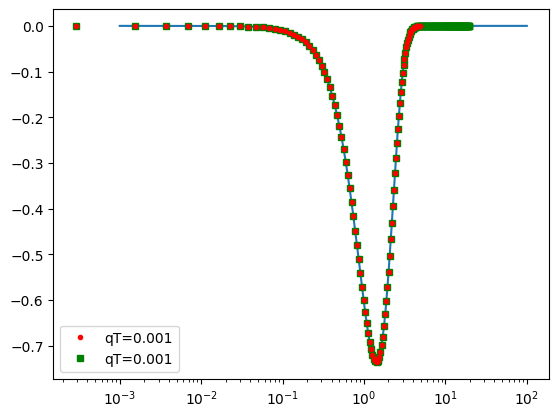

In [21]:
fig=plt.figure()
plt.plot(bT_vals, test_func(bT_vals))
plt.plot(evals[100][0], test_func(evals[100][0]), 'r.', zorder=200, label=f'qT={qT_vals[0]}')
plt.plot(evals[200][0], test_func(evals[200][0]), 'gs', markersize=4,label=f'qT={qT_vals[0]}')
#plt.plot(evals[100][300], test_func(evals[100][300]), 'g.', label = f'qT={qT_vals[300]}')
plt.semilogx()
plt.legend(loc=0)

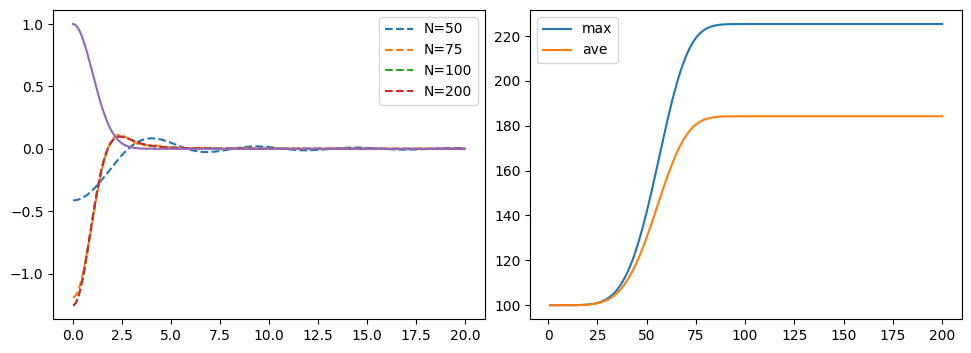

In [22]:
fig = plt.figure(layout='constrained',figsize=[9.6,9.6])
gs = GridSpec(3,2, figure=fig)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0,1])
for NN in [50, 75, 100, 200]:
    ax11.plot(qT_vals, data_arr[NN], linestyle='--',label=f'N={NN}');

ax11.plot(qT_vals, true_func(qT_vals));
#ax11.semilogy()
#ax11.semilogx()
ax11.legend(loc=0)
ax12.plot([i for i in range(1,201)],max_rel_err,label='max');
ax12.plot([i for i in range(1,201)],ave_rel_err,label='ave');
ax12.legend(loc=0);

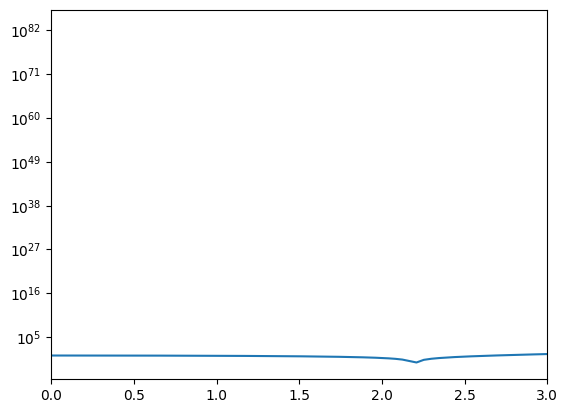

In [23]:
fig=plt.figure()
#plt.plot(qT_vals, (data_arr[100]-true_func(qT_vals))/true_func(qT_vals))
plt.plot(qT_vals, torch.abs((data_arr[200]-true_func(qT_vals))/true_func(qT_vals)))
plt.xlim(0,3)
plt.semilogy()
plt.axhline(0)